In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [15]:
train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')

In [16]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [17]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory

In [19]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(LogisticRegression(max_iter = 100000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                     solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                     fit_intercept = [True, False],
                     C = np.arange(0.1, 2.0, 0.1)),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score)
]           
                 
                 
iterations = 10                
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(LogisticRegression(max_iter = 100000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                     solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                     fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score,
                      n_iter  = iterations)
]

In [20]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [26]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


# Scaling is not relevant for Decision Trees
for data_preparation_strategy in range(1,2):
    if (data_preparation_strategy == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_strategy == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_strategy == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_strategy == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results


        for feature_count in range(1,len(list(X))+1):

            model.seed = 42
            start_time = time.time()              


            # Solution with SelectKBest
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]

            result_table = result_table.append({
             "Model": model_name, 
             "Data Preparation": data_preparation,   
             "Feature Count": feature_count,
             "Feature Selection Technique": "SelectKBest",   
             "Features": best_feature_list.values, 
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,   
             "Raw Model": model.best_estimator_
              }, ignore_index=True)


            # Solution with Recursive Feature Elimination -> only works for some models

            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

               # Traditional RFE
                rfe = RFE(model.estimator, n_features_to_select = feature_count)
                rfe = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name, 
                 "Data Preparation": data_preparation,
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "RFE",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,  
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)

            end_time = time.time()

            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")



        if (model.estimator.__class__.__name__ == 'LogisticRegression'
         or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
         or model.estimator.__class__.__name__ == 'RandomForestClassifier'
         or model.estimator.__class__.__name__ == 'BernoulliNB'
         or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
         or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
         or model.estimator.__class__.__name__ == 'Perceptron'
         or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

            # RFE with Cross Validation -> determines the optimum feature count automatically
            rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
            rfecv = rfe.fit(X,Y)
            best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]


            result_table = result_table.append({
             "Model": model_name,  
             "Data Preparation": data_preparation,
             "Feature Count": len(best_feature_list),
             "Feature Selection Technique": "RFECV",
             "Features": best_feature_list,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)

result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished LogisticRegression with No Scaling and 1 features after 11.72 seconds
Finished LogisticRegression with No Scaling and 2 features after 26.11 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not con

Finished LogisticRegression with No Scaling and 3 features after 61.1 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

Finished LogisticRegression with No Scaling and 4 features after 61.71 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not con

Finished LogisticRegression with No Scaling and 5 features after 69.02 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Scaling and 6 features after 86.41 seconds
Finished LogisticRegression with No Scaling and 7 features after 86.29 seconds
Finished LogisticRegression with No Scaling and 8 features after 101.86 seconds
Finished LogisticRegression with No Scaling and 9 features after 128.57 seconds
Finished LogisticRegression with No Scaling and 10 features after 131.86 seconds
Finished LogisticRegression with No Scaling and 11 features after 135.49 seconds
Finished LogisticRegression with No Scaling and 12 features after 133.21 seconds
Finished LogisticRegression with No Scaling and 13 features after 147.26 seconds
Finished LogisticRegression with No Scaling and 14 features after 188.82 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Scaling and 15 features after 169.32 seconds
Finished LogisticRegression with No Scaling and 16 features after 218.17 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Scaling and 17 features after 251.34 seconds
Finished LogisticRegression with No Scaling and 18 features after 277.7 seconds
Finished LogisticRegression with No Scaling and 19 features after 441.19 seconds
Finished LogisticRegression with No Scaling and 20 features after 578.28 seconds


,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
16,LogisticRegression,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class...",SelectKBest
28,LogisticRegression,No Scaling,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.7000000000000002, 'fit_intercept': Tru...",0.164981,0.102813,"LogisticRegression(C=1.7000000000000002, class...",SelectKBest
22,LogisticRegression,No Scaling,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.8000000000000003, 'fit_intercept': Tru...",0.164981,0.102813,"LogisticRegression(C=1.8000000000000003, class...",SelectKBest
24,LogisticRegression,No Scaling,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.0, 'fit_intercept': True, 'solver': 'n...",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d...",SelectKBest
18,LogisticRegression,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.1, 'fit_intercept': True, 'solver': 'l...",0.162320,0.121516,"LogisticRegression(C=1.1, class_weight=None, d...",SelectKBest
20,LogisticRegression,No Scaling,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.3000000000000003, 'fit_intercept': Tru...",0.159659,0.100227,"LogisticRegression(C=1.3000000000000003, class...",SelectKBest
26,LogisticRegression,No Scaling,14,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.7000000000000002, 'fit_intercept': Tru...",0.159659,0.100227,"LogisticRegression(C=1.7000000000000002, class...",SelectKBest
34,LogisticRegression,No Scaling,18,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 0.8, 'fit_intercept': True, 'solver': 'l...",0.156998,0.111300,"LogisticRegression(C=0.8, class_weight=None, d...",SelectKBest
30,LogisticRegression,No Scaling,16,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.0, 'fit_intercept': True, 'solver': 'l...",0.156998,0.120305,"LogisticRegression(C=1.0, class_weight=None, d...",SelectKBest
36,LogisticRegression,No Scaling,19,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'C': 1.8000000000000003, 'fit_intercept': Tru...",0.154337,0.100877,"LogisticRegression(C=1.8000000000000003, class...",SelectKBest


In [27]:
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
16,LogisticRegression,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class...",SelectKBest
28,LogisticRegression,No Scaling,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.7000000000000002, 'fit_intercept': Tru...",0.164981,0.102813,"LogisticRegression(C=1.7000000000000002, class...",SelectKBest
22,LogisticRegression,No Scaling,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.8000000000000003, 'fit_intercept': Tru...",0.164981,0.102813,"LogisticRegression(C=1.8000000000000003, class...",SelectKBest
24,LogisticRegression,No Scaling,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.0, 'fit_intercept': True, 'solver': 'n...",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d...",SelectKBest
18,LogisticRegression,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.1, 'fit_intercept': True, 'solver': 'l...",0.162320,0.121516,"LogisticRegression(C=1.1, class_weight=None, d...",SelectKBest
20,LogisticRegression,No Scaling,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.3000000000000003, 'fit_intercept': Tru...",0.159659,0.100227,"LogisticRegression(C=1.3000000000000003, class...",SelectKBest
26,LogisticRegression,No Scaling,14,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.7000000000000002, 'fit_intercept': Tru...",0.159659,0.100227,"LogisticRegression(C=1.7000000000000002, class...",SelectKBest
34,LogisticRegression,No Scaling,18,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 0.8, 'fit_intercept': True, 'solver': 'l...",0.156998,0.111300,"LogisticRegression(C=0.8, class_weight=None, d...",SelectKBest
30,LogisticRegression,No Scaling,16,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.0, 'fit_intercept': True, 'solver': 'l...",0.156998,0.120305,"LogisticRegression(C=1.0, class_weight=None, d...",SelectKBest
36,LogisticRegression,No Scaling,19,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'C': 1.8000000000000003, 'fit_intercept': Tru...",0.154337,0.100877,"LogisticRegression(C=1.8000000000000003, class...",SelectKBest


In [8]:
#result_table.to_pickle("result_table_Logistic_Regression.pkl")
result_table = pd.read_pickle("result_table_Logistic_Regression.pkl")

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

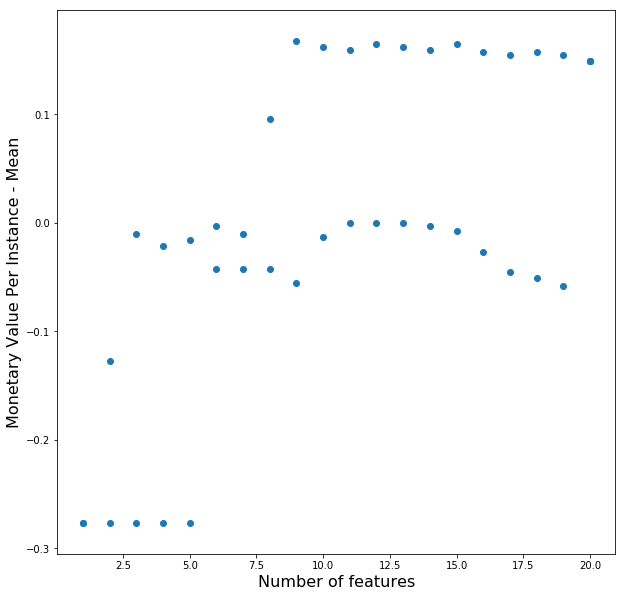

In [9]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [10]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

LogisticRegression(C=1.2000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'lineItemVoidsPerPosition' 'scannedLineItems'
 'pricePerScannedLineItem' 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem']
{'C': 1.2000000000000002, 'fit_intercept': True, 'solver': 'newton-cg'}


In [11]:
coefficients = pd.DataFrame(best_model.coef_[0], best_model_features)
coefficients.columns = ['Value']
coefficients

,Value
trustLevel,-5.624230
totalScanTimeInSeconds,0.004339
lineItemVoids,0.367255
scansWithoutRegistration,0.499503
lineItemVoidsPerPosition,-0.084209
scannedLineItems,0.860581
pricePerScannedLineItem,0.144661
scansWithoutRegistrationPerScannedLineItem,-0.154343
quantityModificationsPerScannedLineItem,0.208809


In [21]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1770
False positive:  5
False negative:  8
True positive:  96
315 for 1879 instances in the test set
0.16764236295902077 per instance in the test set
